# Estimation of Theewaterskloof Dam's Water Surface Area using Sentinel-2 Imagery

This notebook shows how to extract water level of a large water body using satellite imagery. Read the full story
here: https://medium.com/sentinel-hub/global-earth-observation-service-from-your-laptop-23157680cf5e

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

##### The Golden Standard

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

##### For downloading Open Street Map features and manipulation

In [3]:
import geopandas as gpd

In [4]:
from shapely.geometry import MultiLineString, Polygon, MultiPoint, LineString
from shapely.ops import polygonize

##### For downloading satellite imagery

In [5]:
import datetime
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType
from sentinelhub.common import BBox, CRS

##### Image manipulation

In [6]:
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [7]:
from utility import get_polygon

In [8]:
def plot_image(data, factor=1):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = np.zeros(data.shape, dtype=np.float32)
    rgb[..., 0] = data[..., 2]
    rgb[..., 1] = data[..., 1]
    rgb[..., 2] = data[..., 0]
    plt.imshow(rgb*factor)

## Definition of Region of Interest

Lat/Lon vs. Lon/Lat; WGS84 vs. EPSG:3857 vs. ... there's no end to confusion
   * _I always get it wrong_
   * _If all my requests fail, it's because I messed up the coordinates, coordinate systems, ..._

In [9]:
bbox_theewaterskloof_dam=(-33.98,19.11,-34.09,19.3)
bbox=(bbox_theewaterskloof_dam[1],bbox_theewaterskloof_dam[2],bbox_theewaterskloof_dam[3],bbox_theewaterskloof_dam[0])

## Download satellite imagery via Sentinel Hub

To run this example you need Sentinel Hub account. You can get one for free at https://services.sentinel-hub.com/oauth/subscription.

In [10]:
INSTANCE_ID = None

In [12]:
dam_bbox = BBox(bbox=bbox_theewaterskloof_dam, crs=CRS.WGS84)

In [13]:
wcs_true_color_request = WcsRequest(layer='TRUE_COLOR',
                                    bbox=dam_bbox, 
                                    time='2018-02-25', 
                                    maxcc=0.1,
                                    resx='10m', resy='10m',
                                    instance_id=INSTANCE_ID)

In [14]:
wcs_ndwi_request = WcsRequest(layer='NDWI',
                                    bbox=dam_bbox, 
                                    time='2018-02-25', 
                                    maxcc=0.1,
                                    resx='10m', resy='10m',
                                    instance_id=INSTANCE_ID,
                                    image_format=MimeType.TIFF_d32f)

In [15]:
wcs_true_color_img = wcs_true_color_request.get_data()

In [16]:
wcs_ndwi_img = wcs_ndwi_request.get_data()

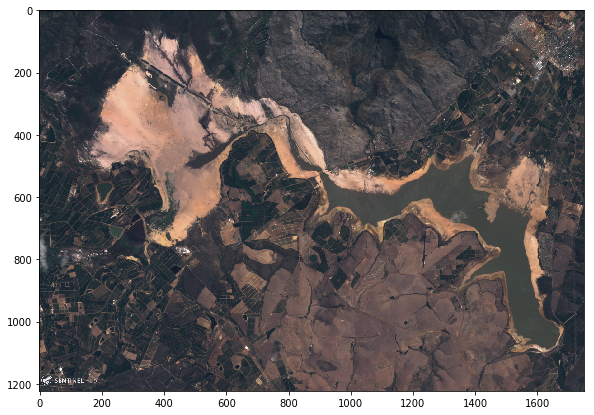

In [17]:
plot_image(wcs_true_color_img[-1], 1./255)

In [18]:
wcs_true_color_request.get_dates()

[datetime.datetime(2018, 2, 25, 8, 39, 18)]

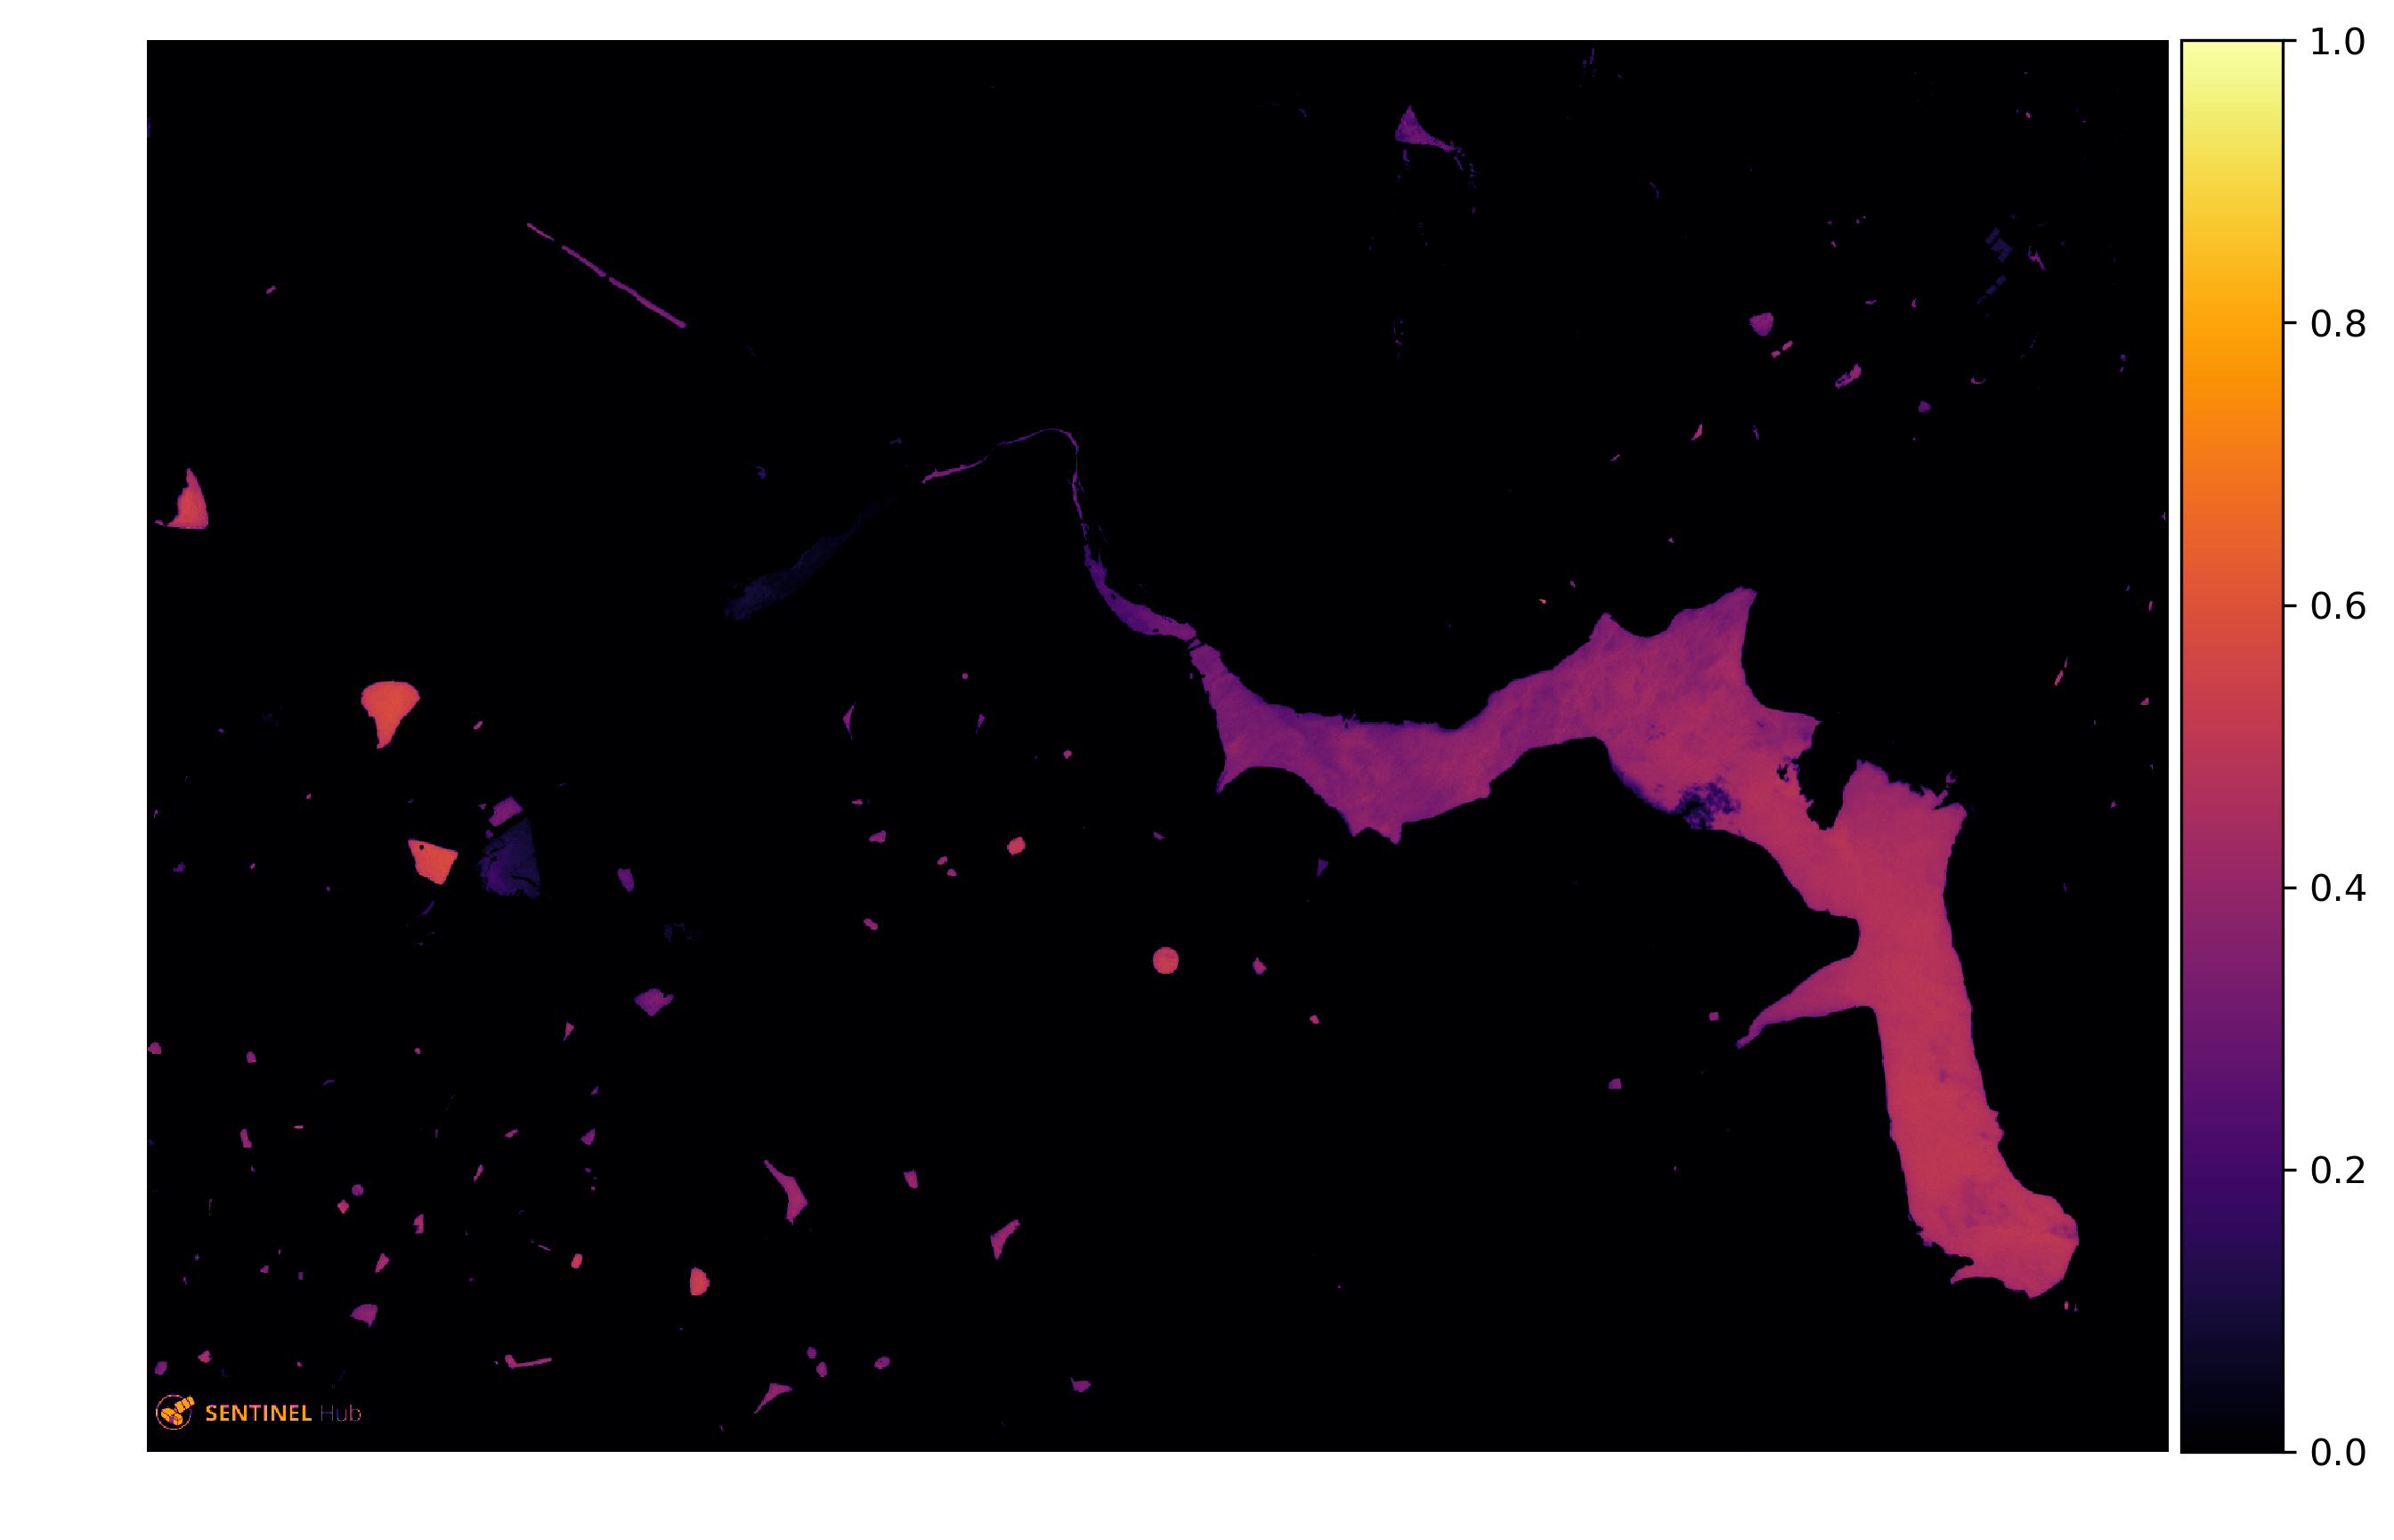

In [20]:
plt.figure(figsize=(15,7),dpi=300)
ax = plt.subplot(111)
im = ax.imshow(wcs_ndwi_img[-1],cmap=plt.cm.inferno, vmin=0, vmax=1)
ax.axis('off')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig("ndwi.png",bbox_inches='tight')

## Run Water Detection

In [21]:
threshold = threshold_otsu(wcs_ndwi_img[-1]); threshold

0.2060717543354258

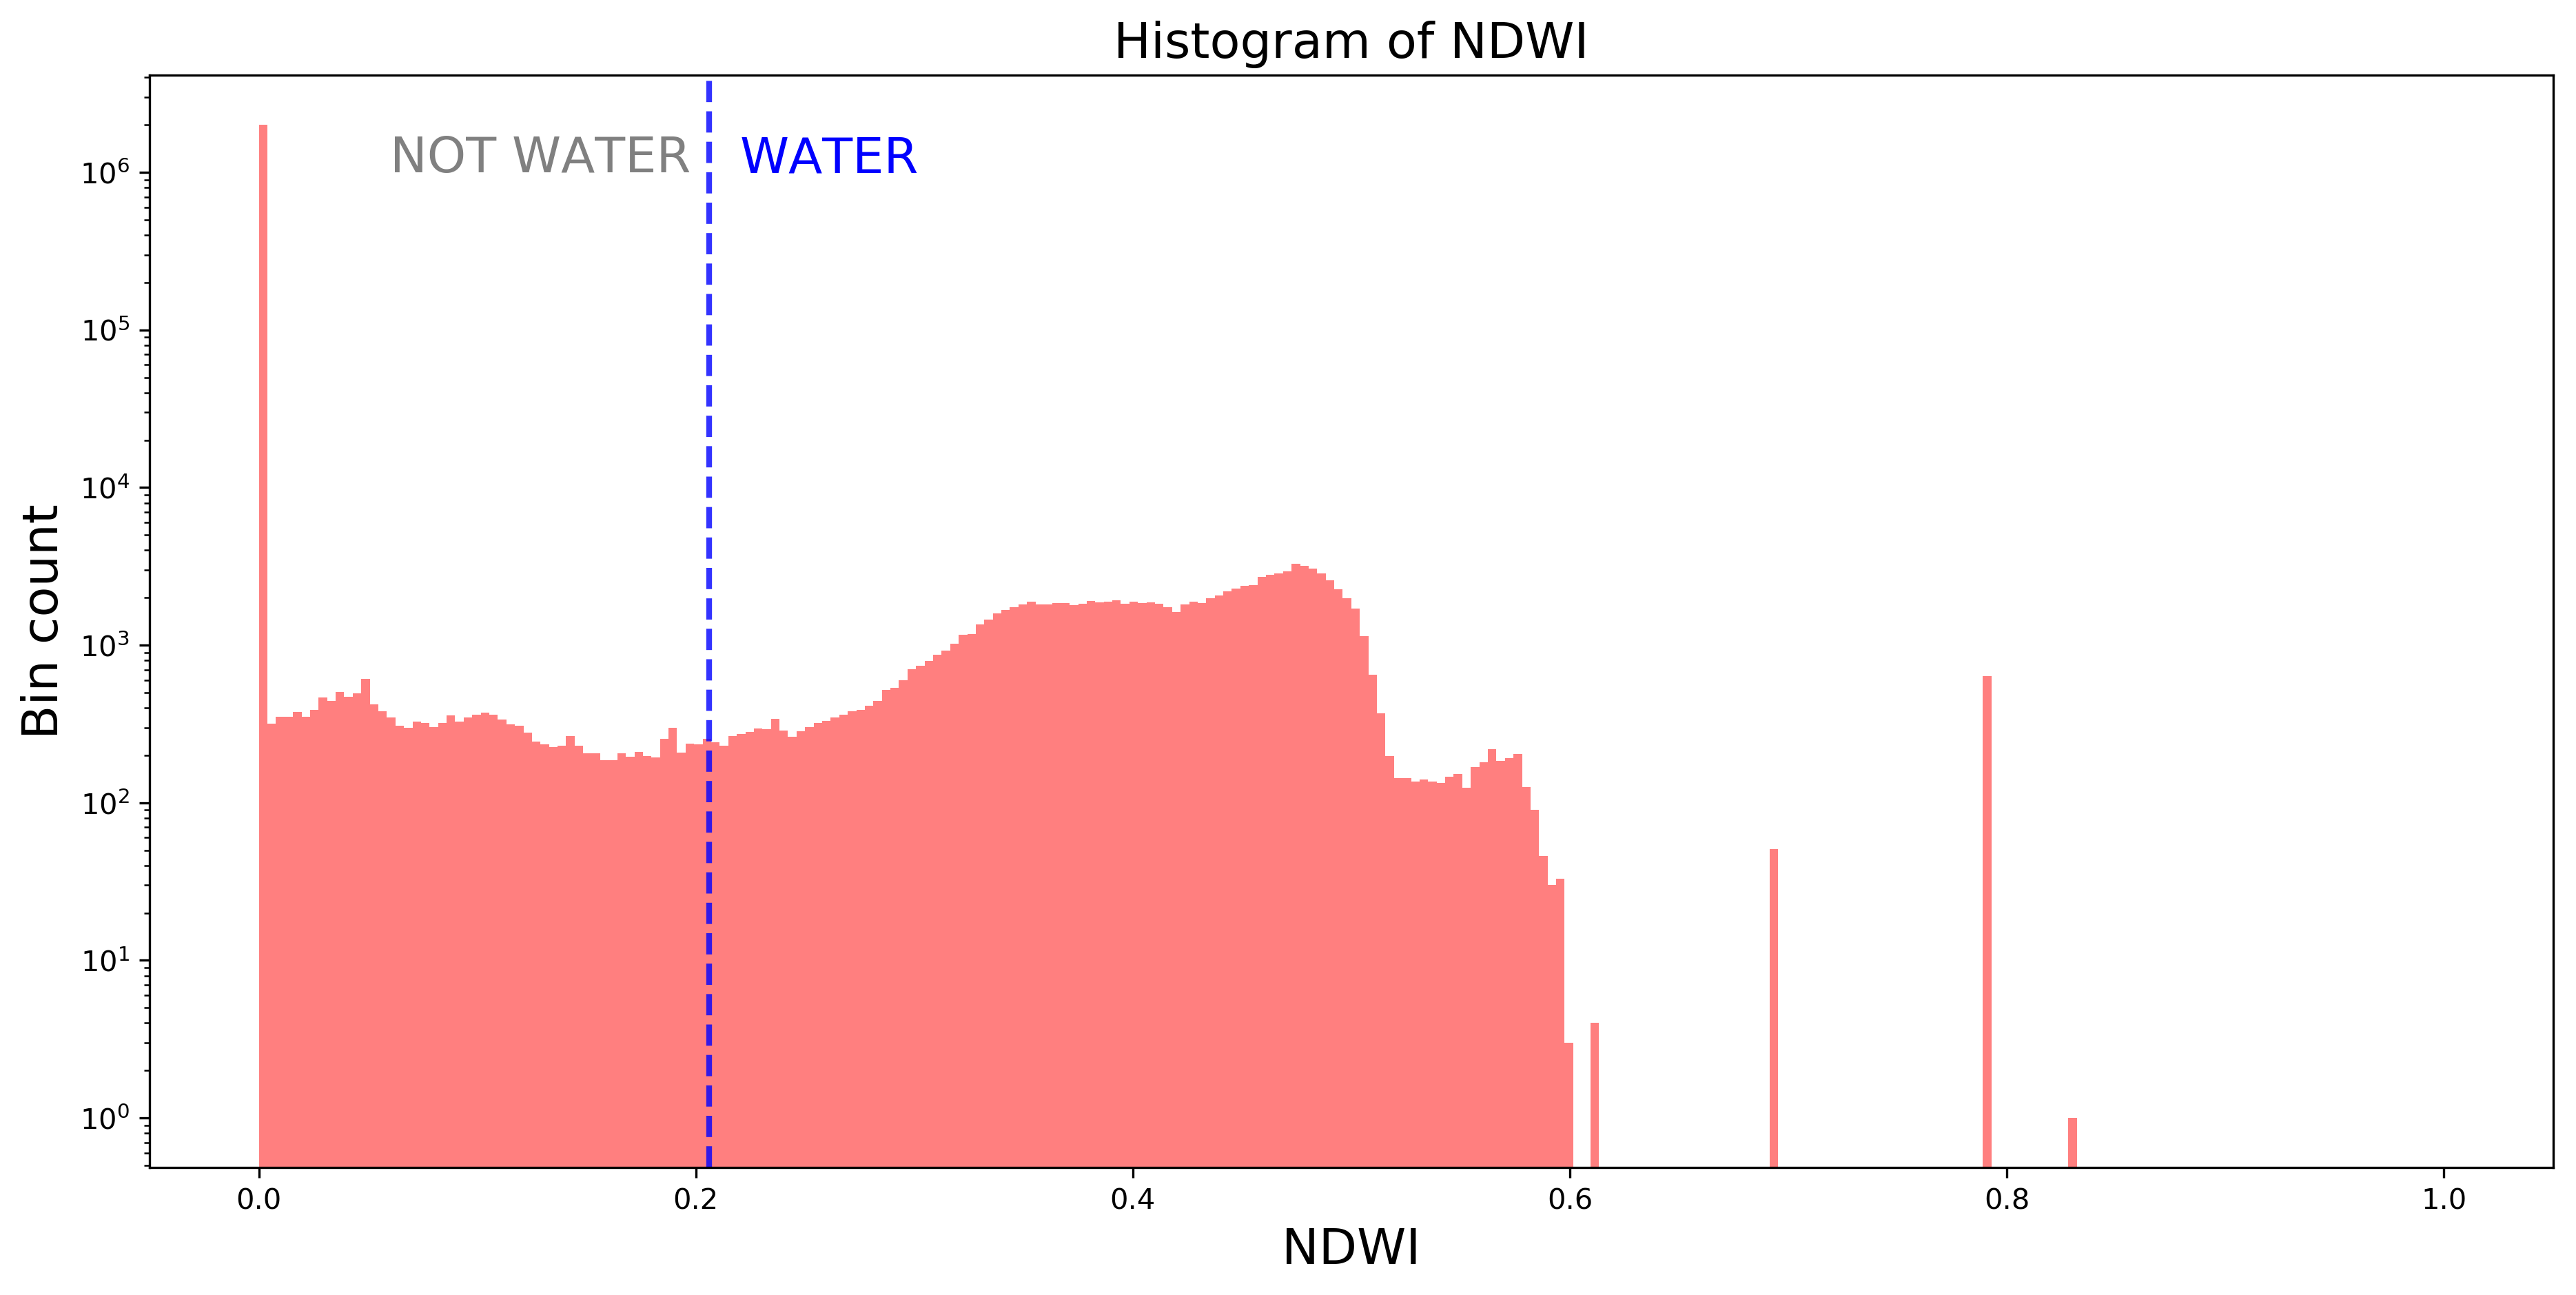

In [22]:
plt.figure(figsize=(15,7),dpi=300)
plt.title('Histogram of NDWI',fontsize='xx-large')
plt.ylabel('Bin count',fontsize='xx-large')
plt.xlabel('NDWI',fontsize='xx-large')
plt.axvline(threshold,c='blue',alpha=0.8,ls='dashed',lw=2)
plt.text(0.22, 10e5, 'WATER',fontsize='xx-large',color='blue')
plt.text(0.06, 10e5, 'NOT WATER',fontsize='xx-large',color='gray')
plt.hist(wcs_ndwi_img[-1].flatten(),bins=256,range=(0,1),log=True,color='r', alpha=0.5);
plt.savefig("ndwi_histogram.png",bbox_inches='tight')

In [23]:
water_ndwi_mask = wcs_ndwi_img[-1]>threshold

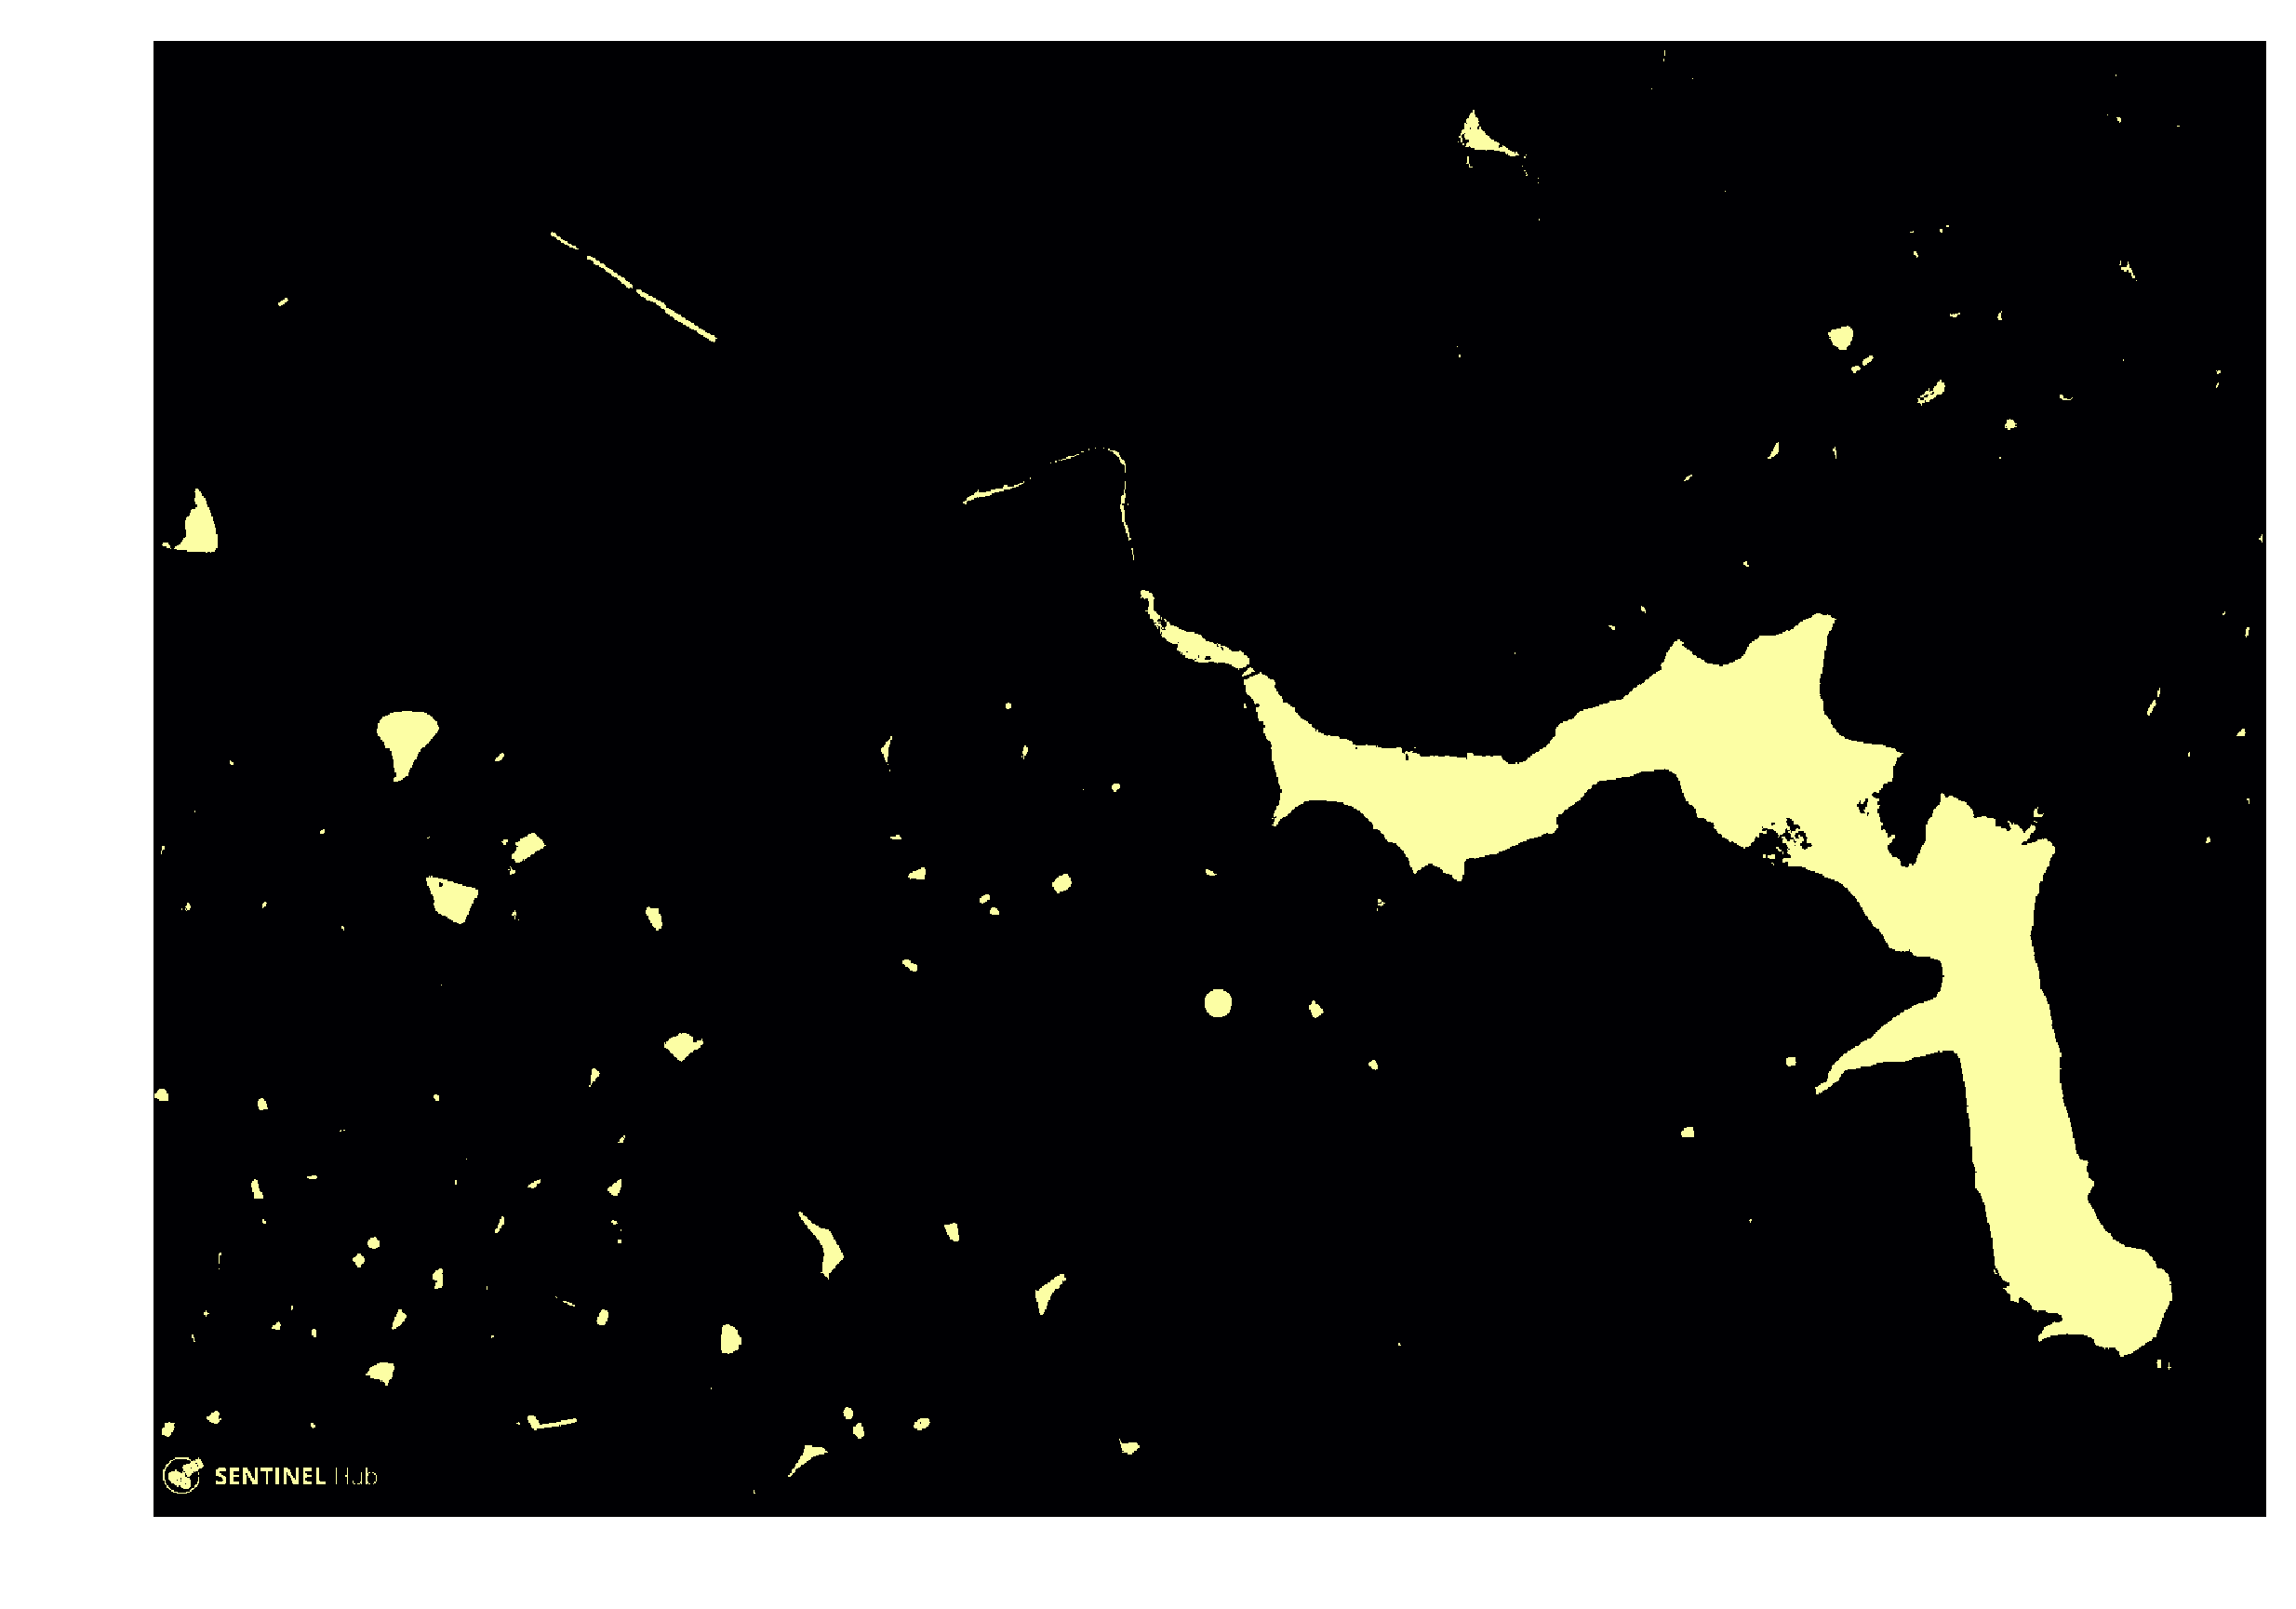

In [24]:
plt.figure(figsize=(15,7),dpi=300)
ax = plt.subplot(111)
im = ax.imshow(water_ndwi_mask,cmap=plt.cm.inferno, vmin=0, vmax=1)
ax.axis('off')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#plt.colorbar(im, cax=cax)

plt.savefig("ndwi_water_mask.png",bbox_inches='tight')

## Get reservoir's contour from Open Street Map

Using a GeoPandas interface to query OpenStreetMap Overpass API

https://www.openstreetmap.org/relation/2526673

In [42]:
import geopandas_osm

In [43]:
df = geopandas_osm.osm.query_osm('relation', bbox=bbox, recurse='down', tags='natural=water')

/Users/ijs/work/git/geopandas_osm/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [44]:
df

geometry         id  leisure  \
373                     POINT (19.2621556 -34.0261094)  582815675  slipway   
0    LINESTRING (19.2102563 -34.0264727, 19.2107674...    6931395      NaN   
1    LINESTRING (19.1385652 -34.0015197, 19.1388606...  187673579      NaN   
2    LINESTRING (19.2869549 -34.03631, 19.2866486 -...  288096221      NaN   
3    LINESTRING (19.2830117 -34.0436183, 19.2828504...  288096224      NaN   

                      name  
373  Theewater Sports Club  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN

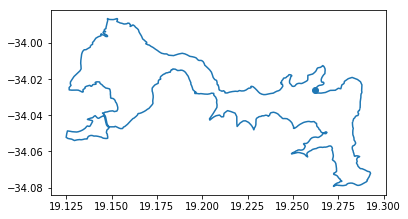

In [45]:
df.plot()

In [51]:
from utility import get_polygon

/Users/ijs/work/git/geopandas_osm/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


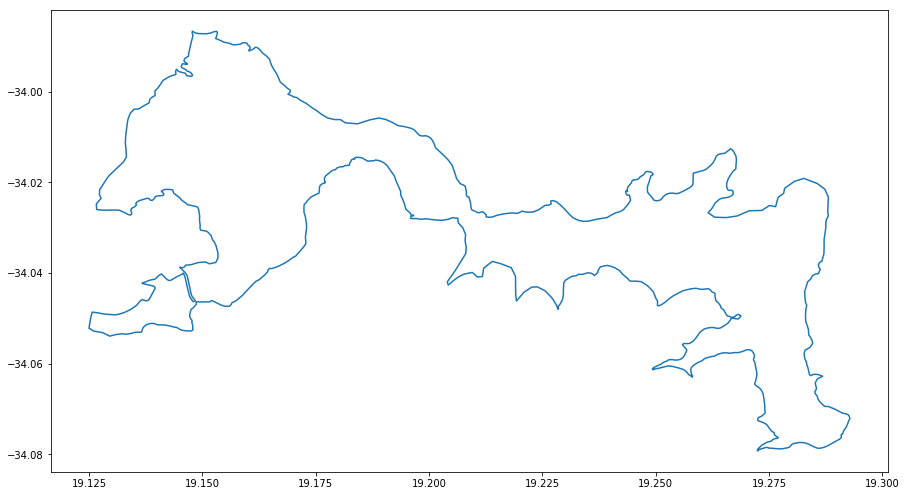

In [52]:
bbox=(19.11,-34.09,19.3,-33.98)
osm_water_mask = get_polygon('relation', bbox=bbox, recurse='down', tags='natural=water', height=1223, width=1751)

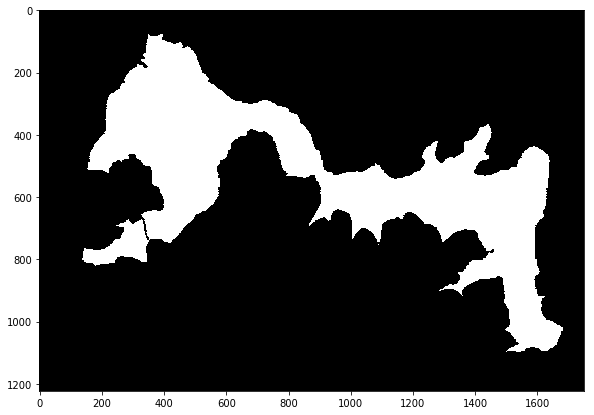

In [53]:
plt.figure(figsize=(15,7))
plt.imshow(osm_water_mask, cmap=plt.cm.gray)

In [54]:
observed = closing(water_ndwi_mask, disk(1))
mask = sobel(osm_water_mask)
observed = sobel(observed)
mask = np.ma.masked_where(mask == False, mask)
observed = np.ma.masked_where(observed == False, observed)

In [56]:
rgb = wcs_true_color_img[-1]
image = np.zeros(rgb.shape, dtype=np.float32)
image[..., 0] = rgb[..., 2]
image[..., 1] = rgb[..., 1]
image[..., 2] = rgb[..., 0]

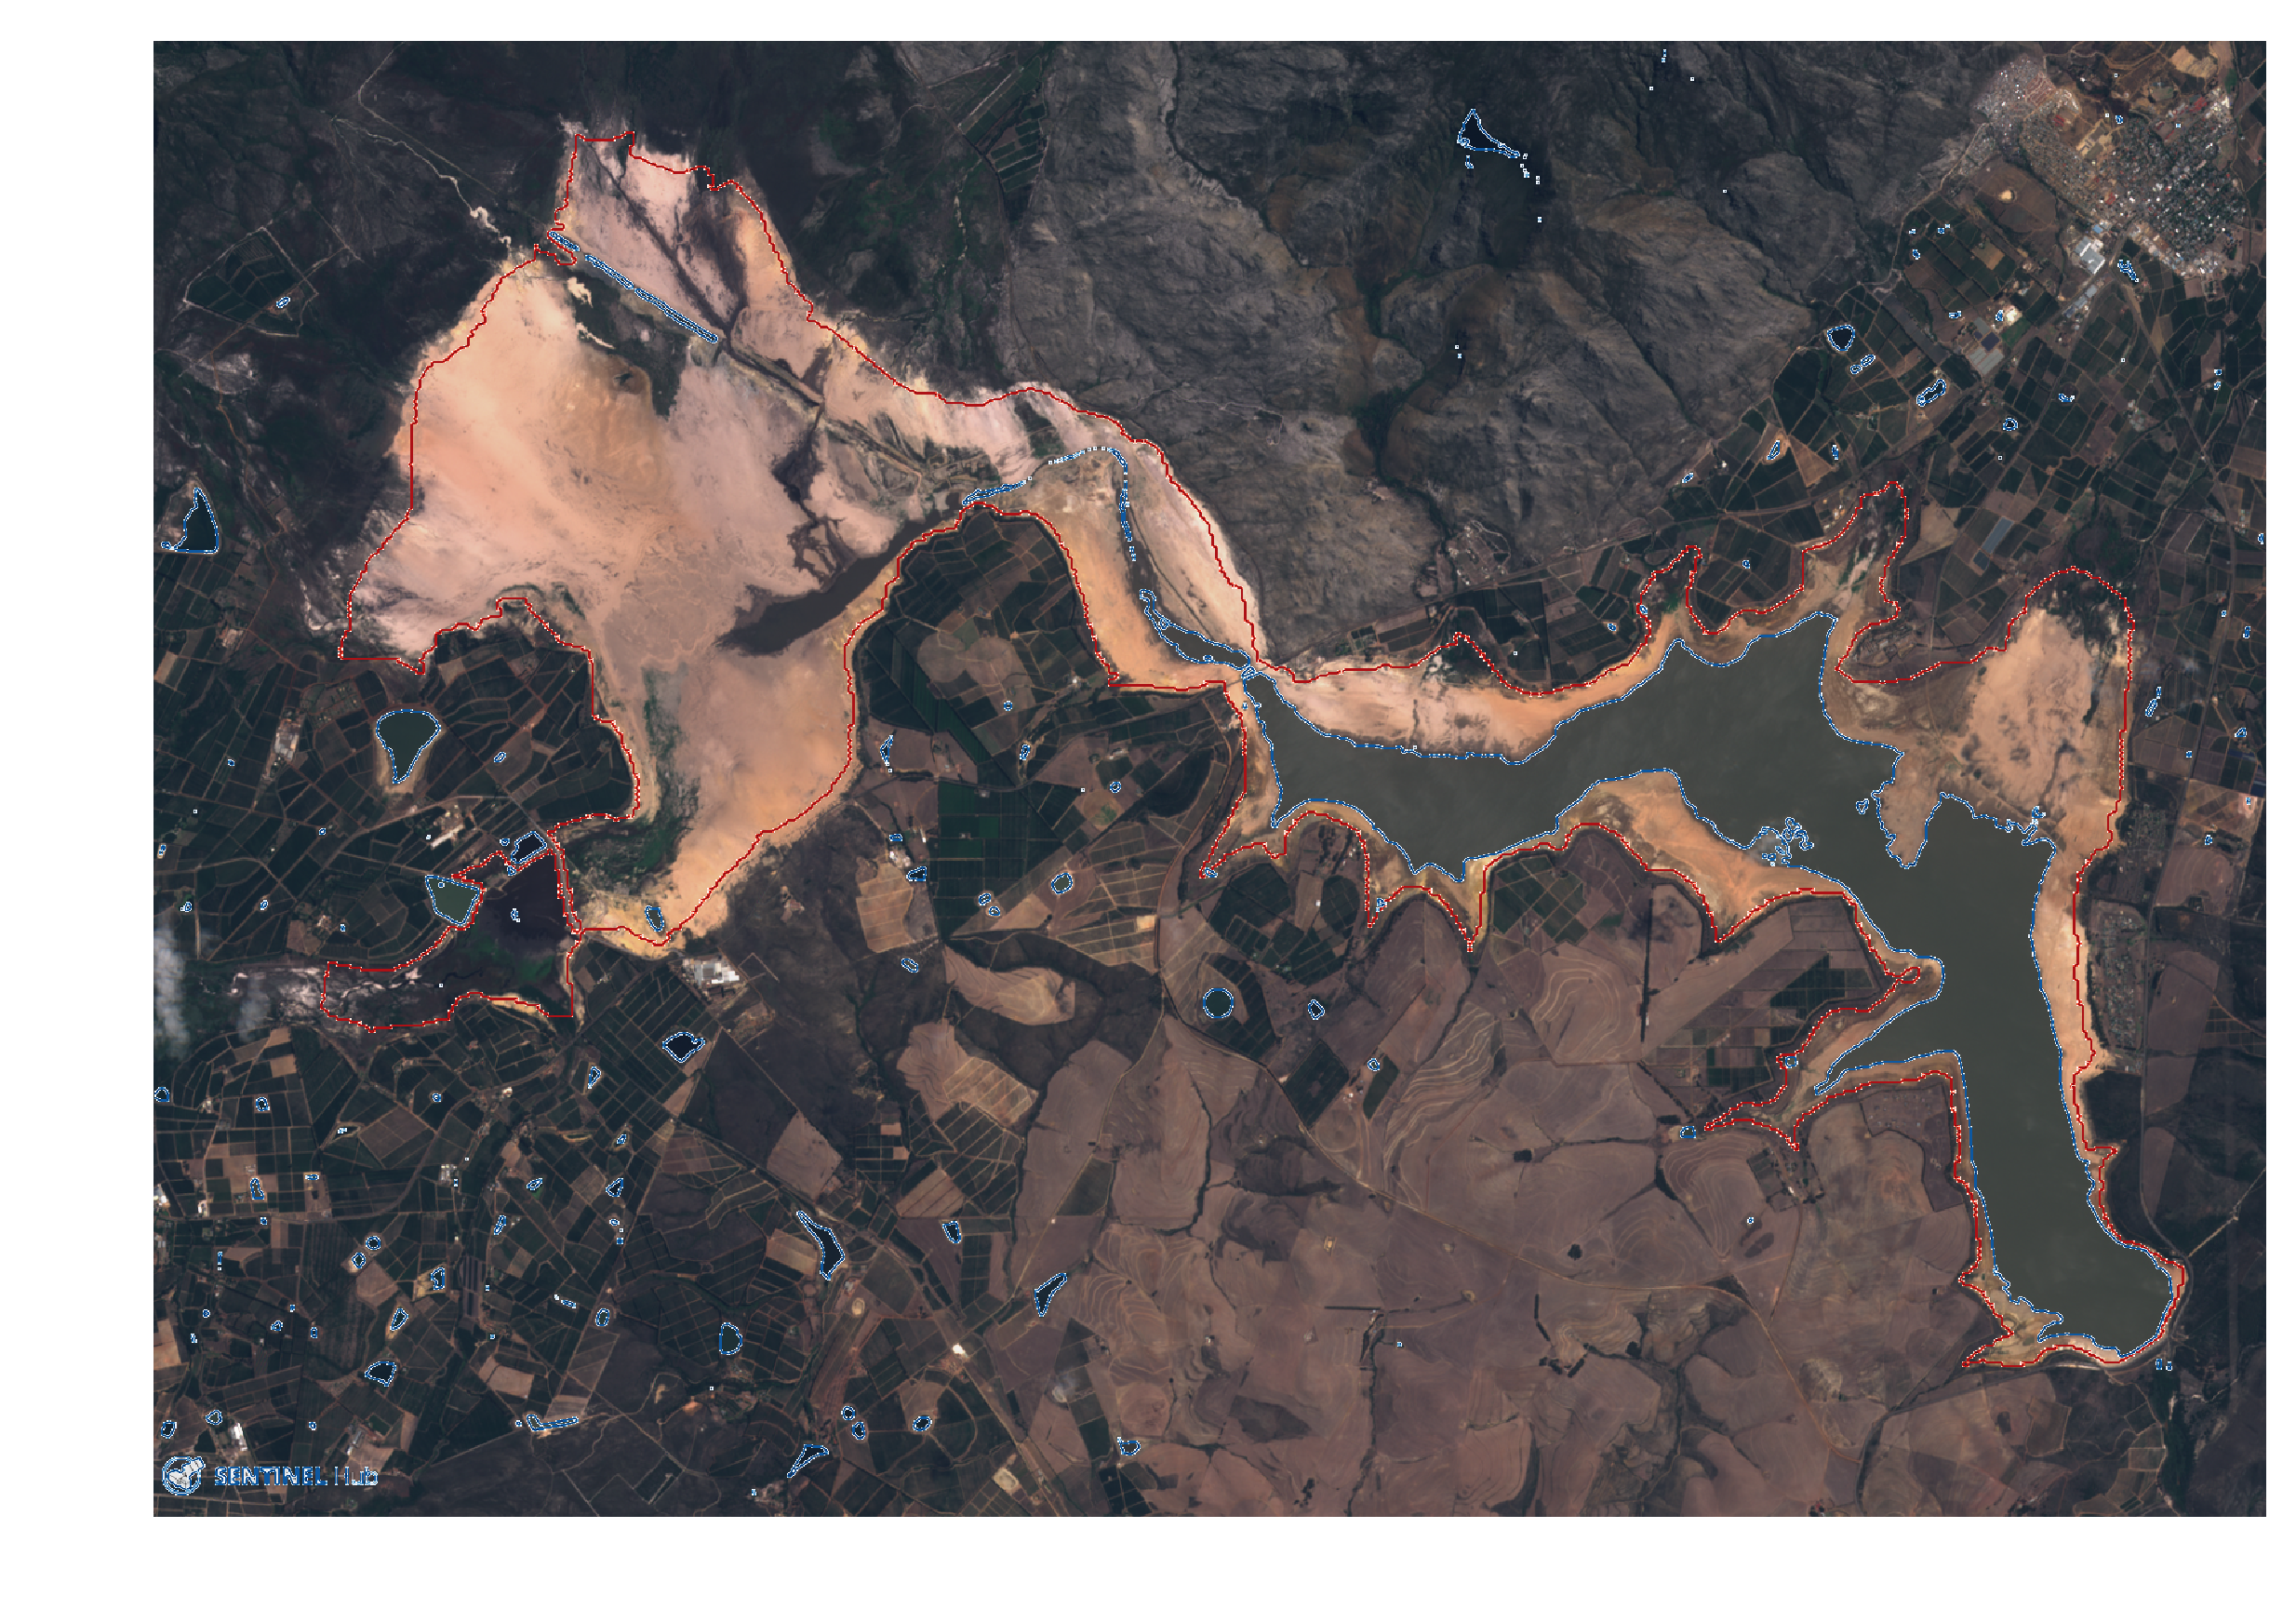

In [57]:
plt.figure(figsize=(15,7),dpi=300)
plt.imshow(image*1./255)
plt.imshow(mask,cmap=plt.cm.Reds)
plt.imshow(observed,cmap=plt.cm.Blues)
plt.axis('off')
plt.savefig('result.png',bbox_inches='tight')



In [58]:
water_level = np.count_nonzero(water_ndwi_mask*osm_water_mask)/np.count_nonzero(osm_water_mask);

In [59]:
water_level

0.23495890008694875